### General Concept

1. Given a pdf file of a bank transaction with multiple pages, get png/jpg of each page.
2. With png/jpg, detect relevant texts (e.g. Tanggal, Keterangan, Mutasi)
3. Put detected text into a DataFrame to be converted into a CSV file that is seperated by semicolons ;

Current issue: Model is not outputting strings clearly

Current solution: Adjust size of image to depict clearer characters for model

### Import Dump

In [14]:
import numpy as np
import cv2
import pandas as pd
import fitz
import matplotlib.pyplot as plt
import pytesseract

### Scanning

First we convert the pdf into a png per page

In [75]:
pdf_name = "Adi.pdf"

doc = fitz.open(pdf_name)

for page in doc:
    pix = page.get_pixmap(dpi=600)
    pix.save("page-%i.png" % page.number)

Use an OCR (optical character recognition) model for reading text

In [76]:
# define tesseract OCT model 
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

Read the images to be put into an Image object in cv2

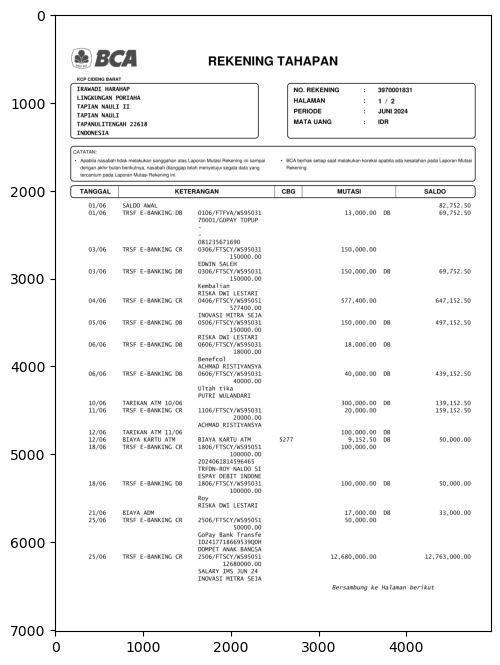

In [141]:
# read png
page = cv2.imread("page-0.png")

# to grayscale for model to easily process
page = cv2.cvtColor(page, cv2.COLOR_BGR2GRAY)

# show page image
plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

Resize the image so that the model processes it faster

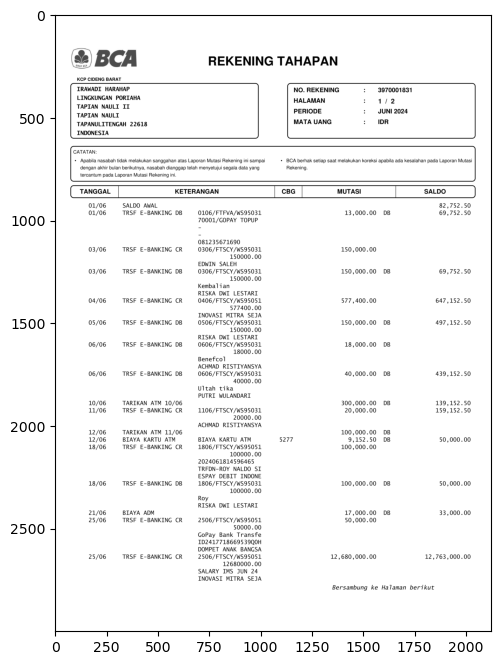

In [142]:
# flexible dimension function
def flexible_dim(img, width=0,height=0):
    if width != 0 and height == 0:
        aspect_ratio = width / img.shape[1]
        height = int(img.shape[0] * aspect_ratio)
        return (width, height)
    elif height != 0 and width == 0:
        aspect_ratio = height / img.shape[0]
        width = int(img.shape[1] * aspect_ratio)
        return (width, height)
    else:
        print("Only change one dimension!")
        return None

# dimension with proper scaling
dim = flexible_dim(page, height=3000)

page = cv2.resize(page, dsize=dim, interpolation=cv2.INTER_AREA)

plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")

The important part of this file is below the row with "Tanggal, Keterangan, ...". So crop this part. Assume that the height ratio proportion of this bank statement to be stable. 

The height crop in this image should be around the 2050th pixel and the image is 7017 pixels high. So the ratio is 2050/7017 which is around 0.298. So crop at the 29.8% height of the image regardless of the image size.

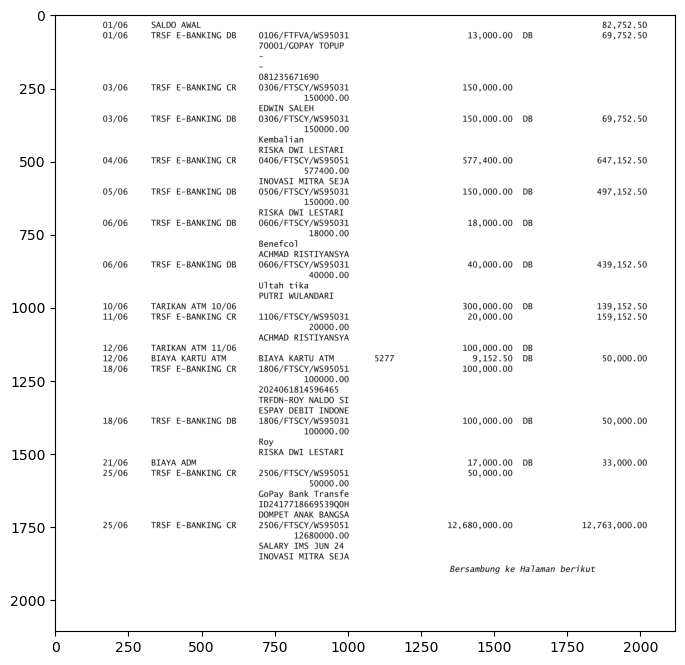

In [143]:
# get page height
page_height = page.shape[0]

page = page[int(page_height * 0.298):, :]

plt.figure(figsize=(30,8))
plt.imshow(page, cmap="gray")


Create a threshold for creating pure monochrome image

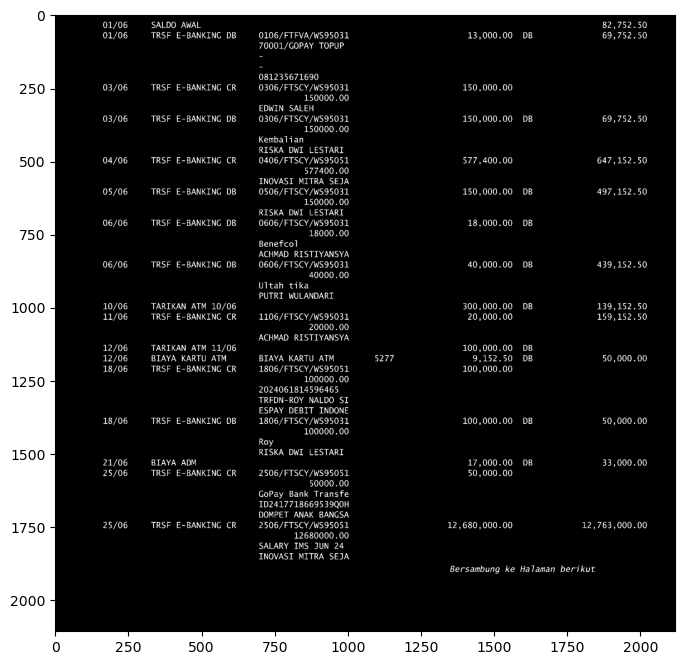

In [144]:
# define threshold
retval, thresh = cv2.threshold(page, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

# show monochrome image
plt.figure(figsize=(30,8))
plt.imshow(thresh, cmap="gray")

Extract text using contours (rectangles around text) more simply for the model to detect characters.

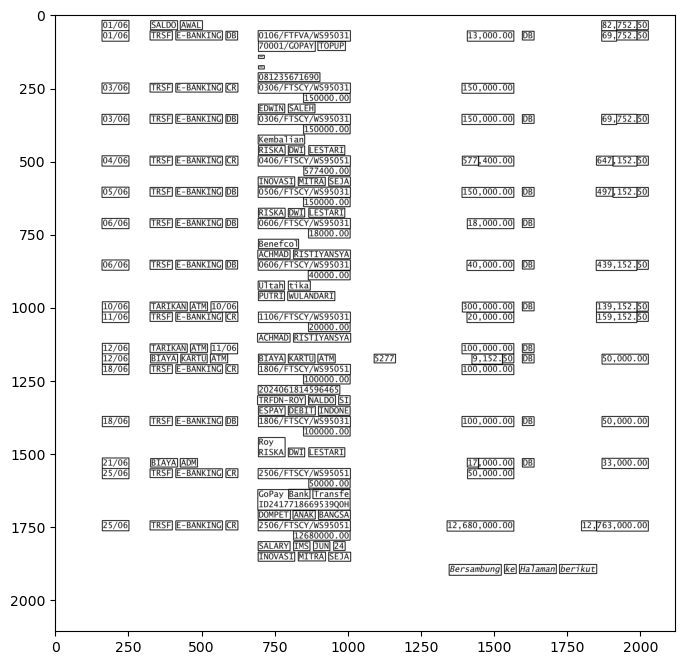

In [148]:
# dilation parameter; bigger tuple = smaller rectangle
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))

# apply dilation to the thresholded monochrome image
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

# find contours and rectangles
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# copy grayscale image from earlier to see the contours
page_copy = page.copy()

# make contour list to store text and its corresponding coordinates
cnt_list = []

# loop for each contour detected
for cnt in contours:

    # get coordinates of contours
    x, y, w, h = cv2.boundingRect(cnt)

    # draw rectangle for each contour
    cv2.rectangle(page_copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # crop text block by rectangle text block
    crop = page_copy[y:y+h, x:x+w]

    # use ocr model cropped image
    text = pytesseract.image_to_string(crop, config="--psm 13")

    # store coordinates and text
    cnt_list.append([x, y, text])

plt.figure(figsize=(30,8))
plt.imshow(page_copy, cmap="gray")

Sort text from left to right and from up to down

In [149]:
sorted_list = sorted(cnt_list, key = lambda x: x[0]) # sort by width first
sorted_list = sorted(sorted_list, key = lambda x: x[1]) # then height

sorted_list

[[160, 18, '01/06\n'],
 [326, 19, 'ISALDO\n'],
 [427, 19, 'AWAL|\n'],
 [1866, 19, '82,\n'],
 [1917, 19, '752.\n'],
 [1987, 19, '50\n'],
 [160, 53, '01/06\n'],
 [693, 53, '0106/FTFVA/WS95031|\n'],
 [324, 54, 'TTRSF\n'],
 [412, 54, 'E-BANKING\n'],
 [1407, 54, '13,000.00\n'],
 [1866, 54, '69,\n'],
 [1917, 54, '752.\n'],
 [1987, 54, '50\n'],
 [583, 55, 'DBI\n'],
 [1595, 55, 'DB|\n'],
 [694, 89, '70001/GOPAY\n'],
 [897, 90, 'TTOPUP)\n'],
 [694, 137, 'i |\n'],
 [694, 173, '— |\n'],
 [693, 197, '081235671690\n'],
 [160, 232, '03/06\n'],
 [693, 232, '0306/FTSCY/WS95031)\n'],
 [324, 233, 'TTRSF\n'],
 [412, 233, 'E-BANK ING\n'],
 [583, 233, 'CR\n'],
 [1389, 233, '150,000.00\n'],
 [848, 268, '150000.00\n'],
 [694, 304, 'EDWIN|\n'],
 [796, 304, 'ISALEH|\n'],
 [160, 339, '03/06\n'],
 [324, 339, 'TTRSF\n'],
 [412, 339, 'E-BANKING\n'],
 [693, 339, '0306/FTSCY/WS95031)\n'],
 [1389, 339, '150,000.00\n'],
 [1866, 339, '69,\n'],
 [1917, 339, '752.\n'],
 [583, 340, 'DBI\n'],
 [1595, 340, 'DBI\n'],
 [1987,

Make into DataFrame for 2D array manipulation to make it cleaner

In [72]:
# create dataframe
df = pd.DataFrame(sorted_list)
df.columns = ["x", "y", "Text"]

df = df.drop(df[(df.Text == "")].index)

df

,x,y,Text
3,4364,88,82\n\n
4,4486,88,752\n\n
6,999,89,AWAL\n\n
10,1621,169,0106/FTFVA/WS95031\n\n
11,759,171,TRSF\n\n
...,...,...,...
236,2184,4338,SEJA\n\n
238,3146,4436,Bersambung\n\n
239,3588,4436,ke\n\n
240,3707,4436,Halaman\n\n
